In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest
from sklearn import preprocessing
from sklearn import metrics
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
#Over Sampling and under sampling libraries
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore");

In [2]:
# Train Dataset

In [3]:
df = pd.read_csv('datasets/train.csv')
df['label'] = df['label'].astype(int)
df = df.drop(columns=['day','transaction_id','card'])
df['time'] = pd.to_timedelta(df['time']).dt.total_seconds()

In [4]:
# Test Dataset

In [11]:
df2 = pd.read_csv('datasets/test.csv')
df2['label'] = df2['label'].astype(int)
df2 = df2.drop(columns=['day','transaction_id','card'])
df2['time'] = pd.to_timedelta(df2['time']).dt.total_seconds()
X_test = df2.drop(columns='label')
y_test = df2['label']
#scaler = preprocessing.StandardScaler().fit(x_test)
#X_test = scaler.transform(x_test)
#X_test = pd.DataFrame(X_test)

In [6]:
X = df.drop('label',axis=1)
#scaler = preprocessing.StandardScaler().fit(X)
#X = scaler.transform(X)
#X = pd.DataFrame(X)
y = df['label']


In [138]:
# Over-sampling followed by under-sampling

In [25]:
from imblearn.combine import SMOTETomek
smt = SMOTETomek(sampling_strategy='auto')
X_smt, y_smt = smt.fit_sample(X, y)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [139]:
# Logistic Regression

Confusion Matrix:
 [[258249  60297]
 [ 31325 286890]]
Accuracy:
 0.8561124189452558
Precision:
 0.8263270226131739
Recall:
 0.9015602658579891
AUC:
 0.9323963565868675


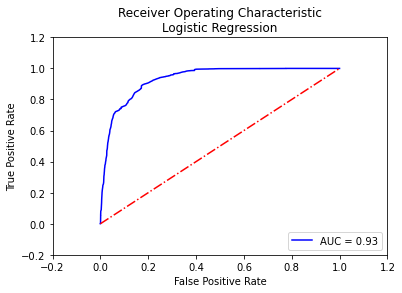

In [33]:
logreg=LogisticRegression()
logreg.fit(X_train,y_train)
y_logreg=logreg.predict(X_val)
y_logreg_prob=logreg.predict_proba(X_val)[:,1]

#Performance metrics evaluation
print("Confusion Matrix:\n",metrics.confusion_matrix(y_val,y_logreg))
print("Accuracy:\n",metrics.accuracy_score(y_val,y_logreg))
print("Precision:\n",metrics.precision_score(y_val,y_logreg))
print("Recall:\n",metrics.recall_score(y_val,y_logreg))
print("AUC:\n",metrics.roc_auc_score(y_val,y_logreg_prob))
auc=metrics.roc_auc_score(y_val,y_logreg_prob)

#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_val,y_logreg_prob)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nLogistic Regression')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [36]:
y_logreg_test=logreg.predict(X_test)

In [37]:
y_logreg_prob = logreg.predict_proba(X_test)[:,1]

In [649]:
threshold = 0.98

In [650]:
prob_thresh = (y_logreg_prob>=threshold).astype('int')

In [651]:
CM_2_Thresh = confusion_matrix(y_test,prob_thresh)
CM_2_Thresh

array([[801808,    864],
       [   626,     24]], dtype=int64)

In [652]:
TN = CM_2_Thresh[0,0]
FP = CM_2_Thresh[0,1]
FN = CM_2_Thresh[1,0]
TP = CM_2_Thresh[1,1]

In [653]:
DR = TP / (TP + FN)
DR

0.036923076923076927

In [654]:
FPR = FP / TP
FPR

36.0

In [655]:
DR_list = []
FPR_list = []
for i in range(len(thresh)):
    threshold = thresh[i]
    prob_thresh_knc = prob_thresh = (y_logreg_prob>=threshold).astype('int')
    CM_2_Thresh = confusion_matrix(y_test,prob_thresh)
    TN = CM_2_Thresh[0,0]
    FP = CM_2_Thresh[0,1]
    FN = CM_2_Thresh[1,0]
    TP = CM_2_Thresh[1,1]
    DR = TP / (TP + FN)
    FPR = FP / TP
    DR_list.append(DR)
    FPR_list.append(FPR)

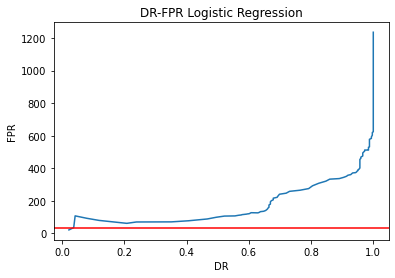

In [659]:
plt.plot(DR_list,FPR_list)
plt.xlabel('DR')
plt.ylabel('FPR')
plt.title('DR-FPR Logistic Regression')
plt.axhline(y=35, color='r', linestyle='-')
plt.show()

In [345]:
#Hyper parameter tuning

In [233]:
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [234]:
grid_log_reg = GridSearchCV(logreg, log_reg_params)

In [235]:
grid_log_reg.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [289]:
tuned_log = grid_log_reg.predict(X_test)

In [290]:
tuned_log_prob = grid_log_reg.predict_proba(X_test)[:,1]

In [328]:
threshold = 0.97

In [329]:
prob_thresh_tuned_log = (tuned_log_prob>=threshold).astype('int')

In [330]:
CM_2_Thresh = confusion_matrix(y_test,prob_thresh_tuned_log )
CM_2_Thresh

array([[800809,   1863],
       [   625,     25]], dtype=int64)

In [331]:
TN = CM_2_Thresh[0,0]
FP = CM_2_Thresh[0,1]
FN = CM_2_Thresh[1,0]
TP = CM_2_Thresh[1,1]

In [332]:
DR = TP / (TP + FN)
DR

0.038461538461538464

In [327]:
FPR = FP / TP
FPR

33.1

In [8]:
X_train

,time,amount,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,...,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23
532338,25473.0,200.70,-436.905041,634.329870,287.048719,-267.363913,-7.422934,49.041834,5.022581,4.297685,...,0.285447,0.269248,-0.410195,0.173407,0.254647,-0.000617,-0.003367,-0.004594,0.001135,0.000008
1023184,24848.0,19.50,-438.670844,644.710083,44.716115,-281.690473,-10.758717,51.384352,5.376517,3.974912,...,-0.477185,-0.322675,-0.389151,0.188269,0.248545,-0.012672,0.021323,-0.001303,0.001047,-0.000007
1056562,28002.0,3741.70,-429.045514,758.942271,99.127839,155.737653,7.762233,-11.313801,-3.518685,4.140258,...,-0.479494,-0.140368,0.175470,-0.006218,-0.020992,-0.009291,-0.012191,-0.000073,-0.023281,-0.000014
721920,30422.0,119.00,-418.922464,-321.245301,-521.829166,-94.585608,-110.403846,-61.105304,-3.434306,3.021532,...,-0.137674,-0.546866,-0.034542,-0.806804,0.017229,0.131375,-0.055138,-0.001806,0.001889,-0.000357
1479919,69788.0,230.00,-439.797892,752.603107,246.685200,164.492684,9.769944,-12.794531,-3.787629,-15.661775,...,0.257025,0.408549,0.160642,-0.026461,-0.021480,-0.001222,-0.032480,0.000109,-0.022572,-0.000006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,60658.0,58.24,-431.678256,-310.864113,-339.903649,49.953036,98.235894,-17.631681,-13.069288,-16.748434,...,-0.570372,0.089825,-0.098985,0.127622,0.054059,-0.046157,-0.118513,-0.012466,-0.006549,-0.000034
1414414,51363.0,18.50,-433.961939,-388.178175,47.259224,-107.314573,117.333848,-80.424735,-12.885994,3.638977,...,-0.987987,0.574118,-0.392383,-0.078016,0.530378,-0.037333,-0.078139,-0.003783,0.001643,-0.000016
131932,24039.0,46.90,-440.660650,644.791155,42.711718,-281.803192,-10.787255,51.402581,5.379253,3.972306,...,-0.476981,-0.322828,-0.389044,0.188275,0.248524,-0.012698,0.021429,-0.001335,-0.022996,-0.000020
671155,48089.0,1158.30,-422.498177,748.383111,-251.007645,-0.619649,41.382954,-165.860871,-4.978320,4.021065,...,0.483985,0.364253,0.290485,-0.054880,-0.096350,0.080098,0.029868,0.004313,0.004728,0.000024


Confusion Matrix:
 [[318359     14]
 [    36    211]]
Accuracy:
 0.9998430732534053
Precision:
 0.9377777777777778
Recall:
 0.854251012145749
AUC:
 0.9608032711255562


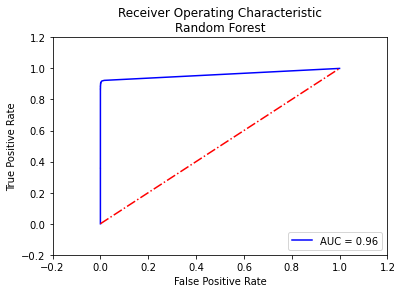

In [9]:
#Random Forest with 'entropy' criterion
from sklearn.ensemble import RandomForestClassifier

rf2=RandomForestClassifier(criterion='entropy',random_state=3)
rf2.fit(X_train,y_train)
y_rf2=rf2.predict(X_val)
y_rf_prob2=rf2.predict_proba(X_val)[:,1]

#Performance metrics evaluation
print("Confusion Matrix:\n",metrics.confusion_matrix(y_val,y_rf2))
print("Accuracy:\n",metrics.accuracy_score(y_val,y_rf2))
print("Precision:\n",metrics.precision_score(y_val,y_rf2))
print("Recall:\n",metrics.recall_score(y_val,y_rf2))
print("AUC:\n",metrics.roc_auc_score(y_val,y_rf_prob2))
auc=metrics.roc_auc_score(y_val,y_rf_prob2)

#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_val,y_rf_prob2)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [13]:
y_rf_test2 =rf2.predict(X_test)

In [14]:
y_rf_prob = rf2.predict_proba(X_test)[:,1]

In [18]:
DR_list = []
FPR_list = []
for i in range(len(thresh)):
    threshold = thresh[i]
    prob_thresh_rf = (y_rf_prob>=threshold).astype('int')
    CM_2_Thresh = confusion_matrix(y_test,prob_thresh_rf )
    TN = CM_2_Thresh[0,0]
    FP = CM_2_Thresh[0,1]
    FN = CM_2_Thresh[1,0]
    TP = CM_2_Thresh[1,1]
    DR = TP / (TP + FN)
    FPR = FP / TP
    DR_list.append(DR)
    FPR_list.append(FPR)

In [135]:
CM_2_Thresh

array([[787869,  14803],
       [   355,    295]], dtype=int64)

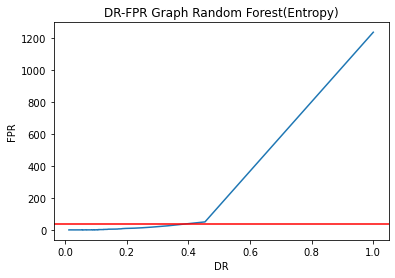

In [19]:
plt.plot(DR_list,FPR_list)
plt.xlabel('DR')
plt.ylabel('FPR')
plt.title('DR-FPR Graph Random Forest(Entropy)')
plt.axhline(y=35, color='r', linestyle='-')
plt.show()

In [132]:
DR_list

[1.0,
 0.45384615384615384,
 0.3323076923076923,
 0.2815384615384615,
 0.24923076923076923,
 0.2246153846153846,
 0.19692307692307692,
 0.18615384615384614,
 0.18153846153846154,
 0.1723076923076923,
 0.17076923076923076,
 0.16307692307692306,
 0.1523076923076923,
 0.14,
 0.13846153846153847,
 0.13692307692307693,
 0.13076923076923078,
 0.12923076923076923,
 0.12615384615384614,
 0.12461538461538461,
 0.12461538461538461,
 0.12461538461538461,
 0.12461538461538461,
 0.12307692307692308,
 0.12,
 0.11384615384615385,
 0.11076923076923077,
 0.10923076923076923,
 0.10923076923076923,
 0.10923076923076923,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10615384615384615,
 0.10307692307692

In [133]:
FPR_list

[1234.88,
 50.047457627118646,
 25.537037037037038,
 17.51366120218579,
 13.358024691358025,
 10.89041095890411,
 9.3671875,
 8.140495867768594,
 6.822033898305085,
 6.258928571428571,
 5.531531531531532,
 5.132075471698113,
 4.828282828282828,
 4.549450549450549,
 4.0777777777777775,
 3.404494382022472,
 3.2588235294117647,
 3.107142857142857,
 3.0,
 2.8271604938271606,
 2.654320987654321,
 2.506172839506173,
 2.3333333333333335,
 2.2,
 2.128205128205128,
 2.135135135135135,
 2.111111111111111,
 2.0422535211267605,
 1.943661971830986,
 1.8169014084507042,
 1.7246376811594204,
 1.681159420289855,
 1.6376811594202898,
 1.536231884057971,
 1.434782608695652,
 1.3333333333333333,
 1.318840579710145,
 1.2753623188405796,
 1.2463768115942029,
 1.1594202898550725,
 1.1304347826086956,
 1.0,
 1.0,
 0.9710144927536232,
 0.9420289855072463,
 0.8840579710144928,
 0.855072463768116,
 0.8507462686567164,
 0.8507462686567164,
 0.8507462686567164,
 0.7611940298507462,
 0.7313432835820896,
 0.7164179

In [20]:
CM_2_Thresh

array([[802672,      0],
       [   642,      8]], dtype=int64)

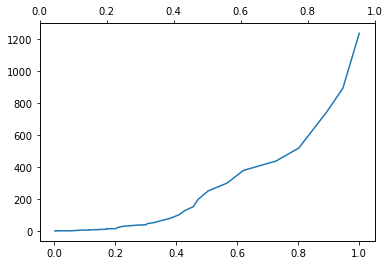

In [630]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

ax1.plot(DR_list,FPR_list)

In [17]:
thresh

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])

In [624]:
DR_list

[1.0,
 0.9461538461538461,
 0.8938461538461538,
 0.8015384615384615,
 0.7261538461538461,
 0.62,
 0.5661538461538461,
 0.5046153846153846,
 0.4707692307692308,
 0.4553846153846154,
 0.42615384615384616,
 0.4076923076923077,
 0.38,
 0.3476923076923077,
 0.3261538461538461,
 0.3046153846153846,
 0.3,
 0.27076923076923076,
 0.2523076923076923,
 0.23384615384615384,
 0.22,
 0.20923076923076922,
 0.20307692307692307,
 0.2,
 0.1723076923076923,
 0.1723076923076923,
 0.1646153846153846,
 0.14615384615384616,
 0.14307692307692307,
 0.12153846153846154,
 0.11384615384615385,
 0.11384615384615385,
 0.09076923076923077,
 0.08307692307692308,
 0.08,
 0.07076923076923076,
 0.07076923076923076,
 0.06923076923076923,
 0.06769230769230769,
 0.06461538461538462,
 0.06153846153846154,
 0.05692307692307692,
 0.05692307692307692,
 0.05692307692307692,
 0.055384615384615386,
 0.046153846153846156,
 0.043076923076923075,
 0.03538461538461538,
 0.03538461538461538,
 0.03230769230769231,
 0.03076923076923077,

In [16]:
thresh = np.arange(0,1,0.01)

In [613]:
thresh[0]

0.0

In [181]:
threshold = 0.02

In [182]:
prob_thresh_rf = (y_rf_prob>=threshold).astype('int')

In [183]:
CM_2_Thresh = confusion_matrix(y_test,prob_thresh_rf )
CM_2_Thresh

array([[797156,   5516],
       [   434,    216]], dtype=int64)

<AxesSubplot:>

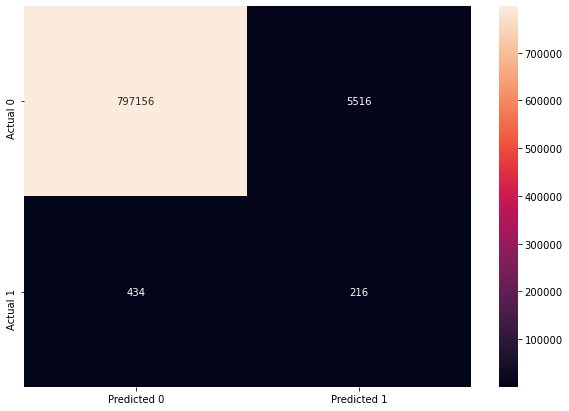

In [188]:
df_cm = pd.DataFrame(CM_2_Thresh, index = ['Actual 0','Actual 1'],
                  columns = ['Predicted 0','Predicted 1'])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,fmt=".0f")

In [185]:
TN = CM_2_Thresh[0,0]
FP = CM_2_Thresh[0,1]
FN = CM_2_Thresh[1,0]
TP = CM_2_Thresh[1,1]

In [186]:
DR = TP / (TP + FN)
DR

0.3323076923076923

In [187]:
FPR = FP / TP
FPR

25.537037037037038

In [192]:
df3 = pd.read_csv('datasets/test.csv')

In [193]:
id = df3['transaction_id']

In [194]:
score = pd.Series(y_rf_prob)

In [195]:
result = pd.concat([id,score],axis=1)

In [196]:
result_df = pd.DataFrame(result)
result_df.rename(columns={0:'score'},inplace=True)

In [197]:
result_df.to_csv('result2.csv',index=False)

Confusion Matrix:
 [[317722    824]
 [     0 318215]]
Accuracy:
 0.9987059508983748
Precision:
 0.9974172436598661
Recall:
 1.0
AUC:
 0.9995510629481567


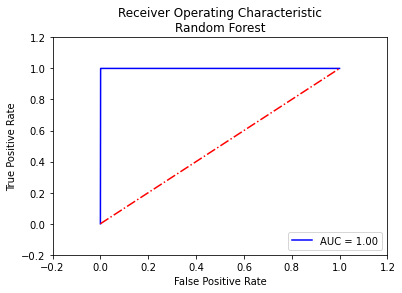

In [563]:
#KNN

knc=KNeighborsClassifier()
knc.fit(X_train,y_train)
y_knc=knc.predict(X_val)
y_knc_prob2=knc.predict_proba(X_val)[:,1]

#Performance metrics evaluation
print("Confusion Matrix:\n",metrics.confusion_matrix(y_val,y_knc))
print("Accuracy:\n",metrics.accuracy_score(y_val,y_knc))
print("Precision:\n",metrics.precision_score(y_val,y_knc))
print("Recall:\n",metrics.recall_score(y_val,y_knc))
print("AUC:\n",metrics.roc_auc_score(y_val,y_knc_prob2))
auc=metrics.roc_auc_score(y_val,y_knc_prob2)

#plotting the ROC curve
fpr,tpr,thresholds=metrics.roc_curve(y_val,y_knc_prob2)
plt.plot(fpr,tpr,'b', label='AUC = %0.2f'% auc)
plt.plot([0,1],[0,1],'r-.')
plt.xlim([-0.2,1.2])
plt.ylim([-0.2,1.2])
plt.title('Receiver Operating Characteristic\nRandom Forest')
plt.legend(loc='lower right')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [361]:
knc_test2 =knc.predict(X_test)

In [362]:
knc_prob = knc.predict_proba(X_test)[:,1]

In [640]:
threshold = 0.9

In [641]:
prob_thresh_knc = (knc_prob>=threshold).astype('int')

In [642]:
CM_2_Thresh = confusion_matrix(y_test,prob_thresh_knc )
CM_2_Thresh

array([[801609,   1063],
       [   580,     70]], dtype=int64)

In [643]:
TN = CM_2_Thresh[0,0]
FP = CM_2_Thresh[0,1]
FN = CM_2_Thresh[1,0]
TP = CM_2_Thresh[1,1]

In [644]:
DR = TP / (TP + FN)
DR

0.1076923076923077

In [645]:
FPR = FP / TP
FPR

15.185714285714285

In [660]:
DR_list = []
FPR_list = []
for i in range(len(thresh)):
    threshold = thresh[i]
    prob_thresh_knc = (knc_prob>=threshold).astype('int')
    CM_2_Thresh = confusion_matrix(y_test,prob_thresh_knc )
    TN = CM_2_Thresh[0,0]
    FP = CM_2_Thresh[0,1]
    FN = CM_2_Thresh[1,0]
    TP = CM_2_Thresh[1,1]
    DR = TP / (TP + FN)
    FPR = FP / TP
    DR_list.append(DR)
    FPR_list.append(FPR)

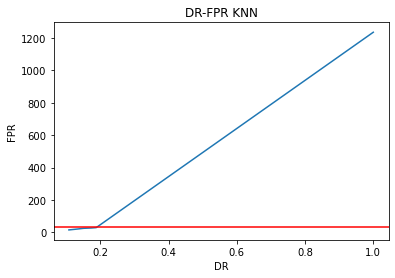

In [661]:
plt.plot(DR_list,FPR_list)
plt.xlabel('DR')
plt.ylabel('FPR')
plt.title('DR-FPR KNN')
plt.axhline(y=35, color='r', linestyle='-')
plt.show()